In [38]:
from datetime import date
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

activity_years = ['2017','2018','2019','2020','2021','2022']
activites_file = 'data/activities.ods'

In [39]:
def get_dataset_single(filename):
        df = pd.read_excel(filename, engine='odf')
        i = pd.DatetimeIndex(df['DATE']).strftime('%Y-%m-%d')
        df = df.set_index(pd.DatetimeIndex(i))
        df['CATEGORY'] = df['CATEGORY'].transform(lambda x: str(x).lower())
        return df

def get_dataset(filename):
        dic = pd.read_excel(filename, engine='odf',sheet_name = activity_years)
        dft = pd.DataFrame()
        for df in dic.values():
            i = pd.DatetimeIndex(df['DATE']).strftime('%Y-%m-%d')
            df = df.set_index(pd.DatetimeIndex(i))
            dft = pd.concat([dft,df], axis=0)
        dft['CATEGORY'] = dft['CATEGORY'].transform(lambda x: str(x).lower())
        return dft
    
df = get_dataset(activites_file)    
df.head()

,DATE,ACTIVITY,CATEGORY,START TIME,DURATION [MIN],DISTANCE [KM],CALORIES,CALORIES BY HR,HR MEDIUM,HR MAX,...,Bones [%],FAT [%],kcal,Unnamed: 32,IF,Unnamed: 33,DIA,SYS,PULSE,Unnamed: 37
DATE,,,,,,,,,,,,,,,,,,,,,
2017-03-28,2017-03-28 22:17:13,walk,fitness,NaN,00:06:18.2,0.33,NaN,NaN,90,119,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-03-29,2017-03-29 18:16:30,running,fitness,NaN,00:29:54,5.07,NaN,NaN,152,177,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-03-31,2017-03-31 18:03:28,cycling,fitness,NaN,00:52:14,20.38,NaN,NaN,127,154,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-04-02,2017-04-02 11:54:20,cycling,fitness,NaN,00:40:51,16.94,NaN,NaN,146,168,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-04-04,2017-04-04 18:26:05,cycling,fitness,NaN,00:42:56,17.50,NaN,NaN,131,152,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [40]:
df['ACTIVITY'].value_counts()


running               438
orbitrek              330
cycling               209
transport             152
briskwalk             113
nothing                93
Orbitrek-hit           59
garden                 41
projects               38
walk                   38
Running-interval       18
tabata                 16
rope                   12
bicycle                12
Inne                    5
travel                  2
Jazda górska            2
stationary bicycle      1
Name: ACTIVITY, dtype: int64

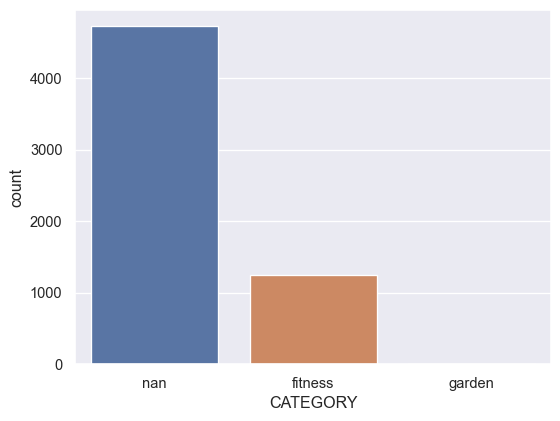

In [41]:
df['CATEGORY'].value_counts().index.tolist()

ax = sns.countplot(x="CATEGORY", data=df,order=df['CATEGORY'].value_counts().index.tolist())


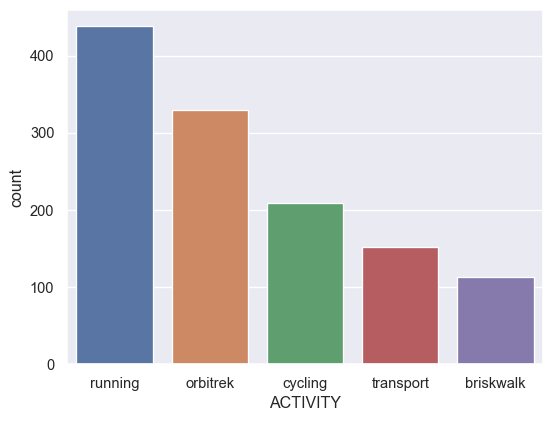

In [42]:
df['ACTIVITY'].value_counts().index.tolist()

ax = sns.countplot(x="ACTIVITY", data=df,order=df['ACTIVITY'].value_counts().index.tolist()[:5])


In [43]:
import re
from datetime import datetime, timedelta

x_2019 = df[df.index.year == 2019]

def round_to_minutes(x):
    assert len(x) != 0
    # duration example 00:05:01.9
    if re.fullmatch("(\d{2})?:(\d{2}):(\d{2}?\.?\d?)",x) is None:
        return round(float(x),2)
    else:
        format = "%H:%M:%S"
        if '.' in x:
            format += '.%f'
        dur=datetime.strptime(x,format)
        td = timedelta(hours=dur.hour,minutes=dur.minute,seconds=dur.second,microseconds=dur.microsecond)
        return round(td.total_seconds() / 60.0, 2)

xx=x_2019['DURATION [MIN]'].transform(lambda x : round_to_minutes(str(x)))
xx

DATE
2019-01-03    31.83
2019-01-05    30.42
2019-01-08    32.30
2019-01-11    31.02
2019-01-13    36.72
              ...  
2019-12-26    30.13
2019-12-27    32.15
2019-12-29    40.12
2019-12-30    35.07
2019-12-31    32.02
Name: DURATION [MIN], Length: 195, dtype: float64

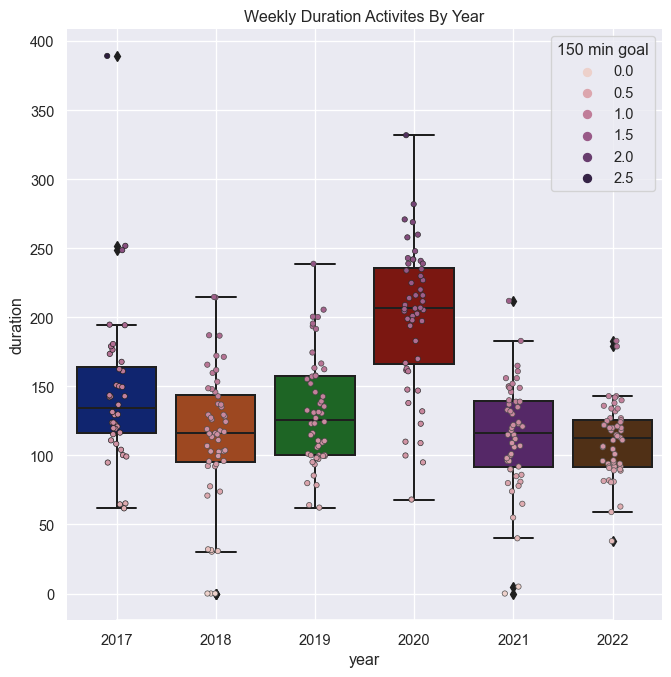

In [44]:
from datetime import datetime

df['duration']=df['DURATION [MIN]'].transform(lambda x : round_to_minutes(str(x)))                            
df2 = df[df.CATEGORY=='fitness']
x=pd.to_timedelta(df2['duration'], unit='min').resample('W-SUN', kind='period').sum()
x = x.transform(lambda x : x.total_seconds() / 60)

df_duration = pd.DataFrame(x)
df_duration['year']=df_duration.index.year
df_duration['week']=df_duration.index.week
df_duration['150 min goal']=df_duration['duration'] / 150.0
df_duration['year'].iat[-1]=df_duration['year'].iat[-2]
df_duration.head()

plt.rcParams.update({"figure.dpi": 96})
f, ax = plt.subplots(figsize=(8, 8))

sns.boxplot(data=df_duration, x='year',y='duration',palette='dark')
f=sns.stripplot(x="year", y="duration", data=df_duration,size=4,linewidth=0.5,hue='150 min goal')
ax.xaxis.grid(True)
sns.despine(trim=True, left=True)
f.set(title="Weekly Duration Activites By Year")

plt.savefig('weekly_activities_duration_by_year.png',dpi=300)